# Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import re

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

# Task and description:

Please develop a model that would forecast next 12 months of Emergency and Normal service calls.  

Data: The dataset provided is related to service calls, specifically:  
when they were received,  
the priority,  
and the town where the service is needed.  

The priority is contained within the request_type column and is either an emergency (E) or normal (N). This data is spread across two tables:

# Read and check data

In [2]:
# Create your connection.
db_path = 'takehomeDB.db'
cnx = sqlite3.connect(db_path)

received_df = pd.read_sql_query("SELECT * FROM RECEIVED", cnx)
req_info_df = pd.read_sql_query("SELECT * FROM REQ_INFO", cnx)

In [3]:
print(received_df.shape)
received_df.head(2)

(529769, 3)


,RECEIVED_DATE,RECEIVED_TIME,KEY
0,2011-12-01 00:00:00,06:12:AM,6123924566510169481
1,2011-12-01 00:00:00,06:40:AM,6550143904606045348


In [4]:
print(req_info_df.shape)
req_info_df.head(2)

(529769, 3)


,REQUEST_TYPE,TOWN_NAME,KEY
0,E,BROOKLINE,6123924566510169481
1,N,BROOKLINE,6550143904606045348


In [5]:
# Quick check number of rows and keys in tables:
assert received_df.KEY.nunique() == received_df.shape[0], 'Key is not unique in received_df'
assert req_info_df.KEY.nunique() == req_info_df.shape[0], 'Key is not unique in req_info df'
assert received_df.shape[0] == req_info_df.shape[0], 'Tables shapes do not match'
assert set(received_df.KEY) == set(req_info_df.KEY), 'Keys do not match'

In [6]:
df = req_info_df.merge(
    received_df, 
    on= 'KEY', 
    how= 'inner'
)
assert df.shape[0] == received_df.shape[0], 'Merge is incorrect'
print(df.shape)
df.head(2)

(529769, 5)


,REQUEST_TYPE,TOWN_NAME,KEY,RECEIVED_DATE,RECEIVED_TIME
0,E,BROOKLINE,6123924566510169481,2011-12-01 00:00:00,06:12:AM
1,N,BROOKLINE,6550143904606045348,2011-12-01 00:00:00,06:40:AM


In [7]:
# Check data distributions
for clmn in ['REQUEST_TYPE', 'TOWN_NAME']: 
    print(f'Column name: {clmn}\n{df[clmn].value_counts()}\n'
          f'Nunique vals: {df[clmn].nunique()}',
          end = '\n'*2)

Column name: REQUEST_TYPE
N    476818
E     52951
Name: REQUEST_TYPE, dtype: int64
Nunique vals: 2

Column name: TOWN_NAME
BARNSTABLE    17482
CAMBRIDGE     16369
NEWTON        14321
FALMOUTH      14206
BOSTON        10607
              ...  
ROCHESTER        72
BOLTON           71
BERLIN           33
DOVER            10
STERLING          8
Name: TOWN_NAME, Length: 158, dtype: int64
Nunique vals: 158



In [8]:
# Extract year and month from data:
year_month_df = pd.DataFrame([c.split('-') for c in df['RECEIVED_DATE']])[[0,1]]
year_month_df.columns = ['YEAR', 'MONTH']
assert year_month_df.shape[0] == df.shape[0], 'Shape do not match'

# Concatenate executed year and month:
old_num_rows = df.shape[0]
df = pd.concat([df, year_month_df], axis= 1)

assert df.shape[0] == old_num_rows, 'Shape do not match'
del old_num_rows

# Experiments with sample of data

To speed up process I always work with sample of data, so here was my fast research and search of appropriate solution for the task. 

In [9]:
tdf = df.sample(1000)
tdf.sort_values(by = ['YEAR','MONTH'], inplace= True)
tdf.reset_index(drop= True, inplace= True)
tdf.head()
tdf = df.copy()
tgrp_df = pd.DataFrame(tdf.groupby(['REQUEST_TYPE', 'TOWN_NAME', 'YEAR', 'MONTH']).KEY.count())
tgrp_df = tgrp_df.reset_index()
tdf = tgrp_df[tgrp_df.TOWN_NAME == 'ABINGTON'].copy()
lag_start = 12
lag_end = 18
for i in range(lag_start, lag_end):
    tdf["lag_{}".format(i)] = tdf.KEY.shift(i)
    
etdf = tdf[tdf.REQUEST_TYPE == 'E'].copy()
ntdf = tdf[tdf.REQUEST_TYPE == 'N'].copy()

In [10]:
# train data - before 2015
# test data - target 2015
etdf

,REQUEST_TYPE,TOWN_NAME,YEAR,MONTH,KEY,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17
0,E,ABINGTON,2011,12,3,NaN,NaN,NaN,NaN,NaN,NaN
1,E,ABINGTON,2012,01,3,NaN,NaN,NaN,NaN,NaN,NaN
2,E,ABINGTON,2012,02,4,NaN,NaN,NaN,NaN,NaN,NaN
3,E,ABINGTON,2012,03,1,NaN,NaN,NaN,NaN,NaN,NaN
4,E,ABINGTON,2012,04,2,NaN,NaN,NaN,NaN,NaN,NaN
5,E,ABINGTON,2012,05,3,NaN,NaN,NaN,NaN,NaN,NaN
6,E,ABINGTON,2012,06,1,NaN,NaN,NaN,NaN,NaN,NaN
7,E,ABINGTON,2012,07,5,NaN,NaN,NaN,NaN,NaN,NaN
8,E,ABINGTON,2012,08,2,NaN,NaN,NaN,NaN,NaN,NaN
9,E,ABINGTON,2012,09,3,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data_clmns = [c for c in etdf.columns if re.match('lag_', c)]
print(len(data_clmns))

# split on train and test: 
X_train = etdf[etdf.YEAR < '2015'][data_clmns].copy()
y_train = etdf[etdf.YEAR < '2015'].KEY
X_test = etdf[etdf.YEAR == '2015'][data_clmns].copy()
y_test = etdf[etdf.YEAR == '2015'].KEY

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

6
(37, 6) (37,)
(11, 6) (11,)


# Work with whole data

## Prepare data

We will use TOWN_NAME and REQUEST_TYPE as encoded features in model

In [12]:
enc_di = {key:val for val, key in enumerate(df[df.YEAR < '2015'].TOWN_NAME.unique())}
print(len(enc_di))

158


In [13]:
# functions to encode city: 
def encode_city(city_name:str, enc_dict:dict): 
    '''Encode city. Return array.'''
    ar = [0] * len(enc_dict)
    ind_ = enc_dict.get(city_name)
    if not pd.isnull(ind_):
        ar[ind_] = 1
    return ar
        
def test_encode_city(enc_dict): 
    assert sum(encode_city('ABINGTOM', enc_dict)) == 0, 'Error with unknown city'
    assert sum(encode_city('ABINGTON', enc_dict)) == 1, 'Error with city which exists'
    return 1

print(test_encode_city(enc_di))

def encode_city_df(df, city_clmn:str, enc_dict:dict):
    '''Encode city. Return df with ohe cities'''
    assert city_clmn in df, f'No {city_clmn} in df'
    
    res_df = pd.DataFrame([encode_city(r, enc_dict) for r in df.TOWN_NAME])
    res_df.columns = [f'enc_city_{i}' for i in enc_dict.values()]
    return pd.concat([df,res_df], axis= 1)

# functions to encode REQUEST_TYPE: 
def encode_req_type(x:str):
    '''Encode request type.'''
    if isinstance(x, str): 
        if x == 'E':
            return 1
        if x == 'N': 
            return 0
        
def encode_req_type_df(df, req_clmn:str): 
    '''Create new column - encoded request column. Return data frame'''
    assert req_clmn in df, f'No {req_clmn} in df'
    df = df.copy()
    df[f'enc_{req_clmn}'.lower()] = df[req_clmn].map(encode_req_type)
    return df

# function to add columns for future modeling:
def add_clmns_for_modeling(df, enc_dict:dict, lag_start:int=12, lag_end:int=18, target_clmn:str='num_calls'):
    '''Add columns to initial data frame for future modeling. Return data frame'''
    df = df.copy()
    for i in range(lag_start, lag_end):
        df["lag_{}".format(i)] = df.num_calls.shift(i)
        
    df = encode_city_df(df, 'TOWN_NAME', enc_dict)
    df = encode_req_type_df(df, 'REQUEST_TYPE')
    # require to check shape after drop
    df.dropna(inplace= True)
    df.reset_index(inplace= True, drop= True)
    return df

1


Group our data by month, can be other time value, but according to task we need to make forecast on future 12 month, so basic unit is month.

In [14]:
grp_df = pd.DataFrame(
    df.groupby(['REQUEST_TYPE', 'TOWN_NAME', 'YEAR', 'MONTH']).KEY.count()).reset_index()
grp_df.rename(columns= {'KEY':'num_calls'}, inplace= True)
grp_df.head(2)

,REQUEST_TYPE,TOWN_NAME,YEAR,MONTH,num_calls
0,E,ABINGTON,2011,12,3
1,E,ABINGTON,2012,01,3


In [15]:
mdl_df = add_clmns_for_modeling(grp_df, enc_di)
print(mdl_df.shape)
mdl_df.head()

(13501, 170)


,REQUEST_TYPE,TOWN_NAME,YEAR,MONTH,num_calls,lag_12,lag_13,lag_14,lag_15,lag_16,...,enc_city_149,enc_city_150,enc_city_151,enc_city_152,enc_city_153,enc_city_154,enc_city_155,enc_city_156,enc_city_157,enc_request_type
0,E,ABINGTON,2013,05,1,3.0,2.0,1.0,4.0,3.0,...,0,0,0,0,0,0,0,0,0,1
1,E,ABINGTON,2013,06,6,1.0,3.0,2.0,1.0,4.0,...,0,0,0,0,0,0,0,0,0,1
2,E,ABINGTON,2013,07,6,5.0,1.0,3.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,E,ABINGTON,2013,08,2,2.0,5.0,1.0,3.0,2.0,...,0,0,0,0,0,0,0,0,0,1
4,E,ABINGTON,2013,09,4,3.0,2.0,5.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# Select columns for modeling: 
mdl_clmns = [c for c in mdl_df.columns if re.match('enc_|lag_', c)]
print(len(mdl_clmns))

165


In [17]:
# split on train and test: 
X_train = mdl_df[mdl_df.YEAR < '2015'][mdl_clmns].copy()
y_train = mdl_df[mdl_df.YEAR < '2015'].num_calls
X_test = mdl_df[mdl_df.YEAR == '2015'][mdl_clmns].copy()
y_test = mdl_df[mdl_df.YEAR == '2015'].num_calls

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10284, 165) (10284,)
(3217, 165) (3217,)


## Train model and plot results

In [18]:
# train simple model:
#lr = LinearRegression() 
lr = Ridge(alpha= 100)
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

In [19]:
# function to plot forecast
def plot_forecast(target, prediction, mae= None, rmse= None, text= None):
    '''Function to plot forecasted and initial time series'''
    # plot time series
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(target.values, label="actual")
    plt.legend(loc="best")
    # create title
    if pd.isnull(text):
        text = 'Linear regression\n' 
    plt.title(
        f'{text} MAE {mae}; RMSE: {rmse}')
    plt.grid(True)
    return 1

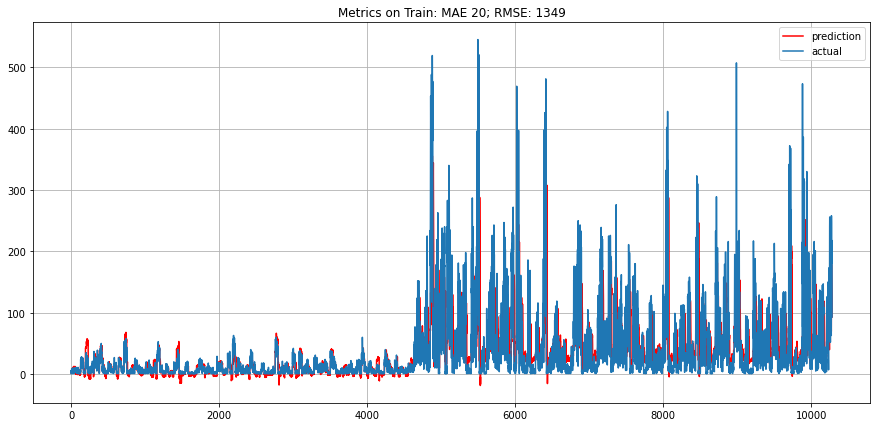

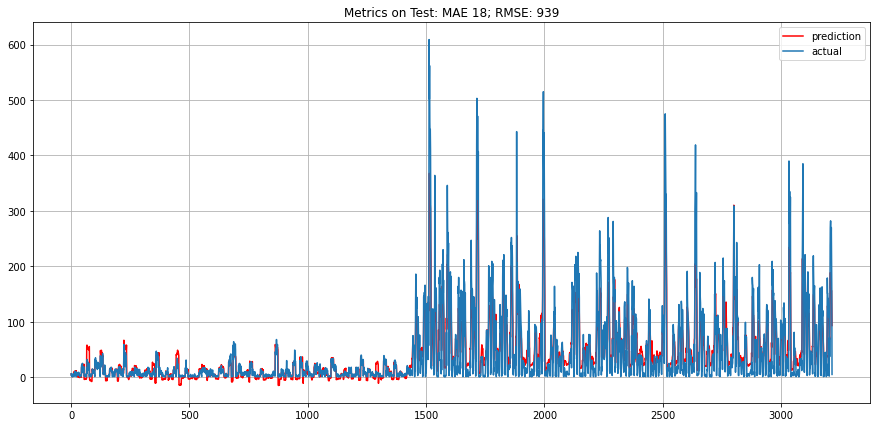

In [20]:
mdl_data_li = [(X_train, y_train), (X_test, y_test)]
labels= ['Metrics on Train:', 'Metrics on Test:']
for label, mdl_data in zip(labels, mdl_data_li):
    target = mdl_data[1]
    prediction = lr.predict(mdl_data[0])
    mae_ = round(mean_absolute_error(target, prediction))
    rmse_ = round(mean_squared_error(target, prediction))
    plot_forecast(target, prediction, mae= mae_, rmse= rmse_, text= label)

Findings: 
1. If we will use regression without regularization we will have outliers in predictions (can be checked by changing Ridge to LinearRegression).  
2. Forecast is poor for REQUEST_TYPE E, there are a lot of under-forecast values (red lines below zero).

It seems, that splitting model to two different models could be better option.  

# Split model to two models request_type E & request_type N

## Split data

In [21]:
mdl_df.REQUEST_TYPE.value_counts()

N    7429
E    6072
Name: REQUEST_TYPE, dtype: int64

In [22]:
nmdl_df = mdl_df[mdl_df.REQUEST_TYPE == 'N'].copy()
nmdl_df.reset_index(drop= True, inplace= True)
# do not need more this column
nmdl_df.drop('enc_request_type', axis=1, inplace= True)
print(nmdl_df.shape)
nmdl_df.head(2)

(7429, 169)


,REQUEST_TYPE,TOWN_NAME,YEAR,MONTH,num_calls,lag_12,lag_13,lag_14,lag_15,lag_16,...,enc_city_148,enc_city_149,enc_city_150,enc_city_151,enc_city_152,enc_city_153,enc_city_154,enc_city_155,enc_city_156,enc_city_157
0,N,ABINGTON,2011,12,32,5.0,5.0,10.0,14.0,8.0,...,0,0,0,0,0,0,0,0,0,0
1,N,ABINGTON,2012,01,9,11.0,5.0,5.0,10.0,14.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
emdl_df = mdl_df[mdl_df.REQUEST_TYPE == 'E'].copy()
# do not need more this column
emdl_df.drop('enc_request_type', axis=1, inplace= True)
emdl_df.reset_index(drop= True, inplace= True)
print(emdl_df.shape)
emdl_df.head(2)

(6072, 169)


,REQUEST_TYPE,TOWN_NAME,YEAR,MONTH,num_calls,lag_12,lag_13,lag_14,lag_15,lag_16,...,enc_city_148,enc_city_149,enc_city_150,enc_city_151,enc_city_152,enc_city_153,enc_city_154,enc_city_155,enc_city_156,enc_city_157
0,E,ABINGTON,2013,05,1,3.0,2.0,1.0,4.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,E,ABINGTON,2013,06,6,1.0,3.0,2.0,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0


## Train models

In [24]:
def train_reg_model(df, use_cols, plot = True, text= None, alpha_= 10):
    '''Train models and plot graphics. Output is trained model'''
    # split data for trian and test
    X_train = df[df.YEAR < '2015'][use_cols].copy()
    y_train = df[df.YEAR < '2015'].num_calls
    X_test = df[df.YEAR == '2015'][use_cols].copy()
    y_test = df[df.YEAR == '2015'].num_calls
    # traim model
    lr = Ridge(alpha= alpha_)
    lr.fit(X_train, y_train)
    
    if plot: 
        # on train
        train_prediction = lr.predict(X_train)
        train_mae_ = round(mean_absolute_error(y_train.values, train_prediction))
        train_rmse_ = round(mean_squared_error(y_train.values, train_prediction))
        plot_forecast(y_train, train_prediction, train_mae_, train_rmse_, text= f'{text}\nMetrics on train:')
        # on test
        test_prediction = lr.predict(X_test)
        test_mae_ = round(mean_absolute_error(y_test.values, test_prediction))
        test_rmse_ = round(mean_squared_error(y_test.values, test_prediction))
        plot_forecast(y_test, test_prediction, test_mae_, test_rmse_,  text= f'{text}\nMetrics on test:')

    return lr

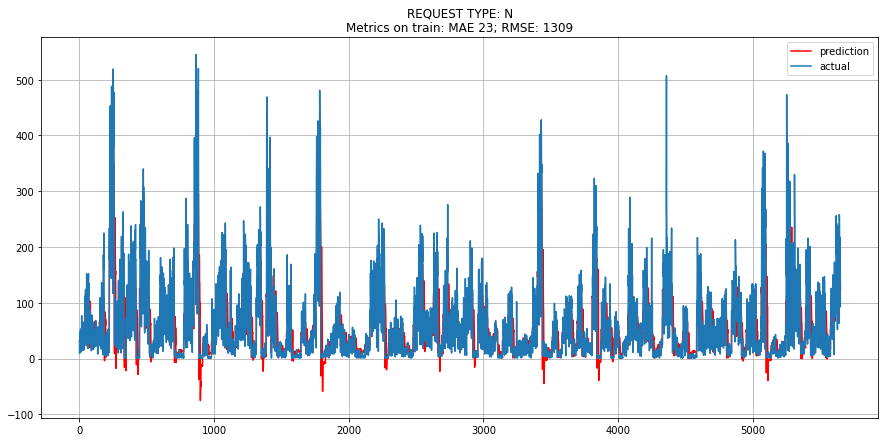

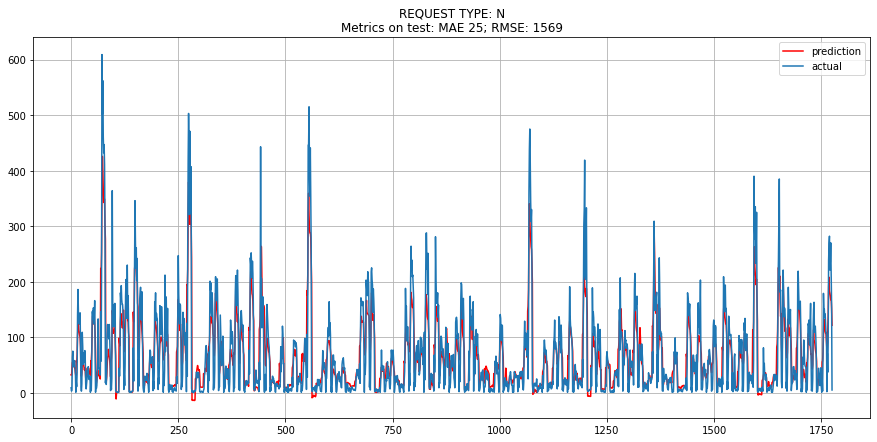

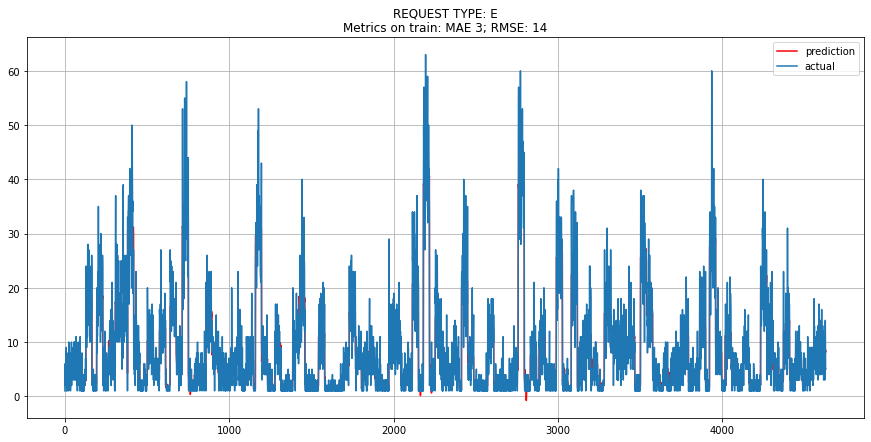

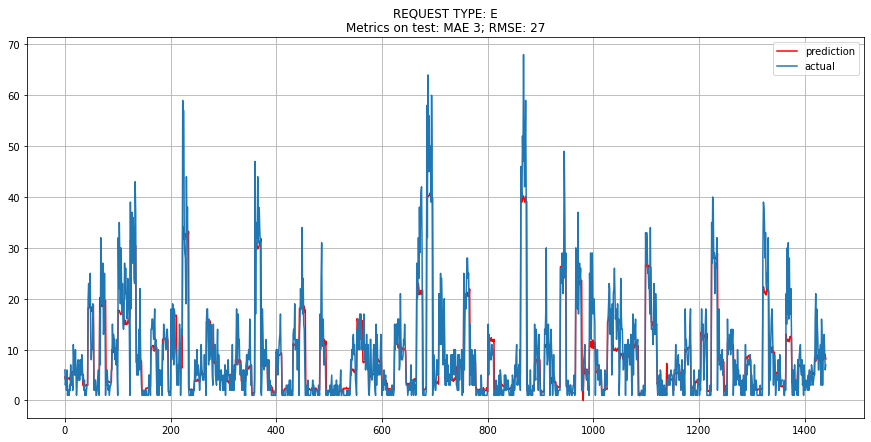

In [25]:
models_di={}
# do not need more this column
new_mdl_clmns = [c for c in mdl_clmns if c != 'enc_request_type']
alpha_li = [10,1]
for df_, name_, alpha_ in zip([nmdl_df, emdl_df], ['N', 'E'], alpha_li):
    models_di[name_] = train_reg_model(df_, new_mdl_clmns, text= f'REQUEST TYPE: {name_}', alpha_= alpha_)

## Results

According to plots:   
1. There are significant under-forecasts on train for normal calls.  
2. Now we have less negative forecasts for emergency phone calls.  
3. Forecasts on test year (2015) seems to be good as they have the same structure as the initial time serie and even peaks are detected.   

# ToDo

1. Train more complex models like xg/cat boost.  
2. Compare with mean target.
3. Choose optimal regularization value on cross validation.